<a href="https://colab.research.google.com/github/lucacontalbo/GraphNeuralNetworks/blob/main/node2vec/node2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Node2Vec implementation

This notebook is a node2vec implementation, done as exercise after following the **CS224W: Machine Learning with Graphs** course by Stanford University (link to online lesson https://www.youtube.com/watch?v=Xv0wRy66Big&list=PLoROMvodv4rPLKxIpqhjhPgdQy7imNkDn&index=8)

In [1]:
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/Colab_Notebooks/ML4Graphs/' #to be changed depending on who runs it

%cd {base_path}

Mounted at /content/drive
/content/drive/MyDrive/Colab_Notebooks/ML4Graphs


In [2]:
import networkx as nx
import numpy as np
import random
from gensim.models import Word2Vec
from pprint import PrettyPrinter
from tqdm import tqdm

pp = PrettyPrinter()

## Initial parameters

In [3]:
params = {
    'epochs': 5,
    'num_walks': 150, #number of walks per node
    'len_walk': 20, #length of walks
    'p': 4, #coefficient for probability of going back to previous node of same walk (probability 1/p)
    'q': 4, #coefficient for probability of going further away from initial node (probability 1/q) -> controls BFS or DFS strategies
    'embedding_dim': 64,
    'weighted': False,
    'directed': False,
    'window_size': 10, #window size for Word2Vec algorithm
    'workers': 6 #number of workers for Word2Vec algorithm
}

input_file = 'edges.txt'
output_file = 'embeddings.txt'

## Graph class and functions

In [4]:
class Walker:
  def __init__(self, graph: nx.classes.graph.Graph, params: dict) -> None:
    self.graph = graph
    self.params = params
    self.alias_nodes = {} #values for the alias method for random sampling (https://lips.cs.princeton.edu/the-alias-method-efficient-sampling-with-many-discrete-outcomes/)
    self.alias_edges = {} #same but it explicitly accounts for edges.
                          #The distinction with alias_nodes is needed to define different behaviours depending on the stage of the walk creation procedure.
                          #if we are at the beginning of the walk, we use alias_nodes, otherwise alias_edges, taking into account the previous transition for calculating the probabilities
                          #given p and q

  def _create_walk(self, start_node: nx.classes.reportviews.NodeView) -> list:
    len_walk = self.params['len_walk']
    alias_nodes = self.alias_nodes
    alias_edges = self.alias_edges
    graph = self.graph

    walk = [start_node]

    for i in range(len_walk-1):
      last_node = walk[-1]
      neighbours = list(graph.neighbors(last_node))
      if len(neighbours) == 0: break
      if len(walk) == 1:
        walk.append(neighbours[self.sample(*alias_nodes[last_node][::-1])])
      else:
        second_last_node = walk[-2]
        walk.append(neighbours[self.sample(*alias_edges[(second_last_node,last_node)][::-1])])

    return walk

  def create_walks(self) -> list:
    nodes = self.graph.nodes()
    num_walks = self.params['num_walks']

    walks = []

    for i in tqdm(range(num_walks)):
      for node in nodes:
        walks.append(self._create_walk(node))

    return walks

  def get_alias(self,probabilities: list) -> tuple[list,list]:
    K = len(probabilities)
    equalizer = np.zeros(K,dtype=np.int32) #list that indicates which overfilling node covers an underfilling one

    underfilling_nodes, overfilling_nodes = [], []

    for idx,prob in enumerate(probabilities):
      if prob > (1/K): overfilling_nodes.append(idx)
      elif prob < (1/K): underfilling_nodes.append(idx)

    while len(overfilling_nodes) > 0:

      overfilling_node, underfilling_node = overfilling_nodes.pop(), underfilling_nodes.pop()
      probabilities[overfilling_node] -= (1/K - probabilities[underfilling_node])
      equalizer[underfilling_node] = overfilling_node

      if round(probabilities[overfilling_node],4) > round(1/K,4): overfilling_nodes.append(overfilling_node)
      elif round(probabilities[overfilling_node],4) < round(1/K,4): underfilling_nodes.append(overfilling_node)
    
    return (equalizer, probabilities)

  def get_alias_edge(self, node1: nx.classes.reportviews.NodeView, node2: nx.classes.reportviews.NodeView) -> tuple[list,list]:
    graph = self.graph
    p = self.params['p']
    q = self.params['q']

    unnormalized_probabilities = [graph[node2][neighbour]['weight']/p if neighbour == node1 #p case: the walk goes back to the previous node
                                  else graph[node2][neighbour]['weight'] if neighbour in graph.neighbors(node1) #standard case: we move to a node which is in the neighbourhood of the previous node
                                  else graph[node2][neighbour]['weight']/q #q case: we move away from the previous node (DFS strategy)
                                  for neighbour in graph.neighbors(node2)]
    
    total_weights = sum(unnormalized_probabilities)
    normalized_probabilities = [prob/total_weights for prob in unnormalized_probabilities]

    return self.get_alias(normalized_probabilities)


  def preprocess_probabilities(self) -> None:
    alias_nodes = {}
    alias_edges = {}
    graph = self.graph
    nodes = graph.nodes()
    directed = self.params['directed']


    for idx_node,node in enumerate(nodes):
      unnormalized_probabilities = [graph[node][neighbour]['weight'] for neighbour in graph.neighbors(node)]
      total_weights = sum(unnormalized_probabilities)
      normalized_probabilities = [prob/total_weights for prob in unnormalized_probabilities]
      alias_nodes[node] = self.get_alias(normalized_probabilities)
    
    self.alias_nodes = alias_nodes

    for edge in graph.edges():
      alias_edges[edge] = self.get_alias_edge(*edge)
      if not directed:
        alias_edges[(edge[1],edge[0])] = self.get_alias_edge(edge[1],edge[0])
    
    self.alias_edges = alias_edges

    return

  def sample(self, probabilities: list, equalizer: list) -> int:
    K = len(probabilities)
    sampled_int = np.random.randint(K)

    if np.random.random()/K < probabilities[sampled_int]:
      return sampled_int
    else:
      return equalizer[sampled_int]


## Model class

In [5]:
class Model:
  def __init__(self, params: list) -> None:
    self.params = params
    self.graph = self.read_graph()
    self.walker = Walker(self.graph,self.params)
    self.model = None
  
  def get_graph(self) -> nx.classes.graph.Graph:
    return self.graph

  def load_model(self) -> None:
    self.model = Word2Vec.load(output_file)

  def predict(self, node: nx.classes.reportviews.NodeView) -> list:
    #print(dir(self.model.wv))
    #print(self.model.wv.key_to_index)
    return self.model.wv[node]

  def read_graph(self) -> nx.classes.graph.Graph:
    weighted = self.params['weighted']
    directed = self.params['directed']

    if weighted:
      graph = nx.read_edgelist(input_file, nodetype=int, data=(('weight',float),), create_using = nx.DiGraph())
    else:
      graph = nx.read_edgelist(input_file, nodetype=int, create_using = nx.DiGraph())
      for edge in graph.edges():
        graph[edge[0]][edge[1]]['weight'] = 1
    
    if not directed:
      graph = graph.to_undirected()

    return graph

  def _train_embeddings(self, walks: list) -> None:
    graph = self.graph
    params = self.params
    new_walks = []
    for walk in walks:
      new_walk = [str(el) for el in walk]
      new_walks.append(walk)
    #walks = [map(str,walk) for walk in walks]
    walks = new_walks
    print(walks)
    self.model = Word2Vec(walks, vector_size=params['embedding_dim'], window=params['window_size'], min_count=0, sg=1, workers=params['workers'], epochs=params['epochs'])
    self.model.save(output_file)

  def train(self) -> None:
    graph = self.graph
    walker = self.walker
    params = self.params

    print("Preprocessing probabilities...")
    walker.preprocess_probabilities()
    print("Done.")
    print("Creation of {} walks with length {}...".format(params['num_walks'],params['len_walk']))
    walks = walker.create_walks()
    print("Done.")
    print("Start training node2vec model...")
    self._train_embeddings(walks)
    print("Training done. Model saved in {}".format(output_file))
    return

In [6]:
model = Model(params)
model.train()

Preprocessing probabilities...
Done.
Creation of 150 walks with length 20...


100%|██████████| 150/150 [00:00<00:00, 280.09it/s]


Done.
Start training node2vec model...
[[1, 20, 2, 1, 20, 2, 31, 34, 33, 9, 34, 15, 33, 3, 1, 8, 1, 20, 34, 20], [32, 26, 25, 26, 25, 28, 3, 28, 34, 19, 33, 19, 34, 10, 3, 1, 11, 6, 11, 1], [22, 1, 32, 33, 31, 33, 19, 34, 33, 15, 34, 27, 30, 24, 33, 30, 24, 34, 15, 33], [20, 34, 20, 34, 15, 33, 23, 33, 30, 34, 33, 34, 30, 27, 34, 16, 33, 19, 34, 16], [18, 1, 9, 3, 33, 19, 34, 30, 27, 34, 21, 33, 34, 32, 33, 24, 30, 27, 30, 27], [14, 1, 22, 2, 1, 32, 33, 32, 29, 34, 27, 34, 28, 3, 4, 3, 9, 33, 21, 34], [13, 4, 13, 4, 8, 1, 8, 4, 2, 14, 3, 29, 32, 34, 10, 34, 29, 32, 34, 33], [12, 1, 20, 34, 10, 34, 21, 34, 33, 24, 30, 34, 32, 29, 32, 29, 34, 33, 32, 26], [11, 6, 1, 32, 25, 26, 32, 26, 32, 25, 26, 24, 28, 3, 4, 14, 2, 4, 3, 1], [9, 3, 14, 4, 3, 1, 2, 8, 1, 18, 2, 18, 1, 5, 7, 17, 7, 6, 17, 7], [8, 3, 2, 4, 14, 2, 14, 3, 1, 4, 3, 10, 3, 4, 8, 3, 29, 32, 33, 19], [7, 6, 1, 9, 34, 27, 30, 27, 34, 31, 33, 21, 34, 33, 32, 34, 33, 19, 34, 33], [6, 17, 6, 7, 1, 11, 6, 1, 7, 6, 17, 7, 17, 6, 7, 

## Clustering

We test the embeddings we have just calculated for a clustering task and we visualize everything

In [10]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

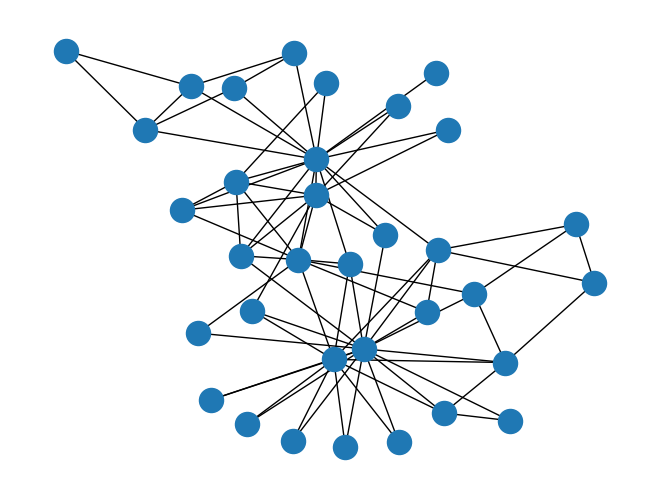

In [8]:
#visualize the graph
graph = model.get_graph()

nx.draw_kamada_kawai(graph)

In [11]:
nodes = graph.nodes()
embeddings = []
model.load_model()

for node in nodes:
  node_emb = model.predict(node)
  embeddings.append(model.predict(node))

embeddings = np.array(embeddings)
embeddings.shape

(34, 64)

In [12]:
df = pd.DataFrame(embeddings)

In [27]:
# Feature Extraction with PCA - unsupervised
from sklearn.decomposition import PCA
# feature extraction
pca = PCA(n_components=3)
fit = pca.fit(df)
# summarize components
print("Explained Variance:", fit.explained_variance_ratio_)
pca_df = fit.transform(df)
pca_df.shape

Explained Variance: [0.4850579  0.16034727 0.10737922]


(34, 3)

In [37]:
param_grid = {'eps': list(np.arange(0.05, 1, 0.05)), 'min_samples': list(range(1,10,1))}
params = list(ParameterGrid(param_grid))

sil_thr = 0  # visualize results only for combinations with silhouette above the threshold
unc_thr = 5 # visualize results only for combinations with unclustered% below the threshold

In [38]:
best_params = []
for el in tqdm(params):
    dbs = DBSCAN(algorithm='auto', eps=el['eps'], leaf_size=10, metric='euclidean',
       metric_params=None, min_samples=el['min_samples'], n_jobs=None, p=None)

    clustering_labels = dbs.fit_predict(pca_df)
    n_clusters = len(np.unique(clustering_labels))
    if n_clusters > 1 and n_clusters < len(pca_df):
        silhouette = silhouette_score(pca_df,clustering_labels)
    else:
        silhouette = -1
    p_unclust = (len(pca_df)-len(dbs.core_sample_indices_))/len(pca_df)
    tmp = np.array([el['eps'],el['min_samples'],n_clusters,silhouette,p_unclust*100])
    if silhouette > sil_thr and p_unclust*100 < unc_thr:
        if len(best_params) == 0:
            best_params = np.array([tmp])
        else:
            best_params = np.vstack([best_params,tmp])

names = ['eps','min_samples','n_clusters','silhouette','unclust%']
pd.DataFrame(best_params,columns=names)

100%|██████████| 171/171 [00:00<00:00, 726.20it/s]


,eps,min_samples,n_clusters,silhouette,unclust%
0,0.05,1.0,32.0,0.078685,0.000000
1,0.10,1.0,29.0,0.100059,0.000000
2,0.15,1.0,21.0,0.270883,0.000000
3,0.20,1.0,17.0,0.459094,0.000000
4,0.25,1.0,14.0,0.480664,0.000000
5,0.30,1.0,11.0,0.529475,0.000000
6,0.35,1.0,10.0,0.560675,0.000000
7,0.40,1.0,9.0,0.595534,0.000000
8,0.45,1.0,6.0,0.492837,0.000000
9,0.45,2.0,6.0,0.492837,2.941176


In [39]:
dbs = DBSCAN(algorithm='auto', eps=0.6, leaf_size=10, metric='euclidean',
       metric_params=None, min_samples=2, n_jobs=None, p=None)

clustering_labels = dbs.fit_predict(pca_df)

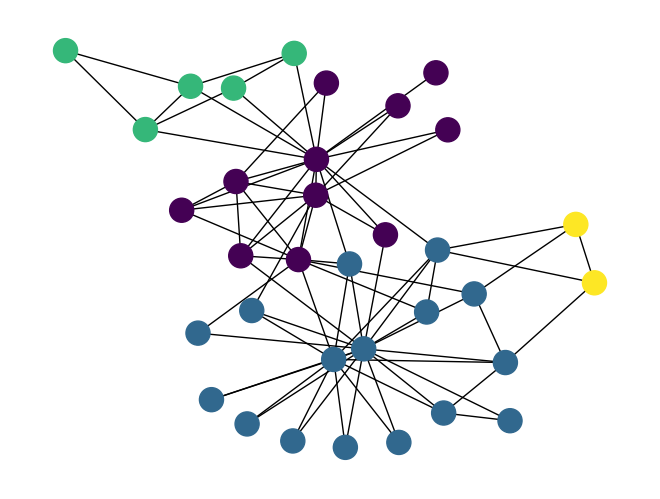

In [40]:
#visualize the graph
graph = model.get_graph()

nx.draw_kamada_kawai(graph, node_color=clustering_labels)

We have shown how to implement the node2vec model and applied a clustering algorithm like DBSCAN to cluster the nodes, showing graphically that the features calculated from the node2vec step are able to provide good feature embeddings for each node.